In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [2]:
# Load hyperspectral image and ground truth labels
data = sio.loadmat('/content/PaviaU.mat')['paviaU']  # (145, 145, 200)
labels = sio.loadmat('/content/PaviaU_gt.mat')['paviaU_gt']  # (145, 145)

print(f"Original Data Shape: {data.shape}")  # (145, 145, 200)
print(f"Original Labels Shape: {labels.shape}")  # (145, 145)


Original Data Shape: (610, 340, 103)
Original Labels Shape: (610, 340)


In [3]:
# Flatten data to 2D for PCA transformation
data_reshaped = data.reshape(-1, 103)  # (10249, 200)

# Apply PCA to reduce spectral dimension
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data_reshaped)

# Reshape back to 3D (145, 145, 50)
data_pca = data_pca.reshape(610, 340, 50)

print(f"PCA Reduced Shape: {data_pca.shape}")  # (145, 145, 50)


PCA Reduced Shape: (610, 340, 50)


In [4]:
def create_patches(X, y, patch_size=7, depth=7):
    half = patch_size // 2
    band_half = depth // 2

    # Pad spatially and spectrally
    padded_data = np.pad(X, ((half, half), (half, half), (band_half, band_half)), mode='constant')

    X_patches, y_patches = [], []
    for row, col in zip(*np.where(y > 0)):  # Ignore background (0)
        patch = padded_data[row: row + patch_size, col: col + patch_size, band_half: band_half + depth]
        X_patches.append(patch)
        y_patches.append(y[row, col])  # Original label

    return np.array(X_patches), np.array(y_patches)

# Extract patches
X_patches, y_patches = create_patches(data_pca, labels)

# Reshape for 3D CNN (Add channel dimension)
X_patches = X_patches.reshape(-1, 7, 7, 7, 1)

print(f"Final Data Shape: {X_patches.shape}")  # (num_samples, 7, 7, 7, 1)
print(f"Labels Shape: {y_patches.shape}")  # (num_samples,)


Final Data Shape: (42776, 7, 7, 7, 1)
Labels Shape: (42776,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_patches, y_patches, test_size=0.25, random_state=42)

print(f"Training Data Shape: {X_train.shape}")  # (~70% of total)
print(f"Testing Data Shape: {X_test.shape}")  # (~30% of total)


Training Data Shape: (32082, 7, 7, 7, 1)
Testing Data Shape: (10694, 7, 7, 7, 1)


In [6]:
num_classes = len(np.unique(y_train))  # Should be 16 or 17
y_train = to_categorical(y_train - 1, num_classes)  # Adjust for 0-indexing
y_test = to_categorical(y_test - 1, num_classes)

print(f"One-Hot Encoded Labels Shape: {y_train.shape}")  # (train_samples, 16)


One-Hot Encoded Labels Shape: (32082, 9)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(7, 7, 7, 1), padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 1)),  # Reduce pooling along spatial dimensions, keep depth

    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 1)),  # Prevent excessive reduction in depth

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 7, 7, 7, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 7, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 3, 3, 7, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 3, 3, 7, 64)         │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 3, 7, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 1, 1, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,273 (450.29 KB)

 Trainable params: 115,081 (449.54 KB)

 Non-trainable params: 192 (768.00 B)

None


In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Epoch 1/20
1003/1003 - 7s - 7ms/step - accuracy: 0.9925 - loss: 0.0250 - val_accuracy: 0.9964 - val_loss: 0.0109
Epoch 2/20
1003/1003 - 8s - 8ms/step - accuracy: 0.9957 - loss: 0.0150 - val_accuracy: 0.9889 - val_loss: 0.0510
Epoch 3/20
1003/1003 - 5s - 5ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.9959 - val_loss: 0.0202
Epoch 4/20
1003/1003 - 5s - 5ms/step - accuracy: 0.9964 - loss: 0.0112 - val_accuracy: 0.9982 - val_loss: 0.0107
Epoch 5/20
1003/1003 - 4s - 4ms/step - accuracy: 0.9971 - loss: 0.0096 - val_accuracy: 0.9970 - val_loss: 0.0113
Epoch 6/20
1003/1003 - 5s - 5ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9975 - val_loss: 0.0085
Epoch 7/20
1003/1003 - 4s - 4ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 0.9960 - val_loss: 0.0139
Epoch 8/20
1003/1003 - 6s - 6ms/step - accuracy: 0.9969 - loss: 0.0097 - val_accuracy: 0.9926 - val_loss: 0.0267
Epoch 9/20
1003/1003 - 5s - 5ms/step - accuracy: 0.9968 - loss: 0.0103 - val_accuracy: 0.9972 - 

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9969 - loss: 0.0121
Test Accuracy: 0.9959


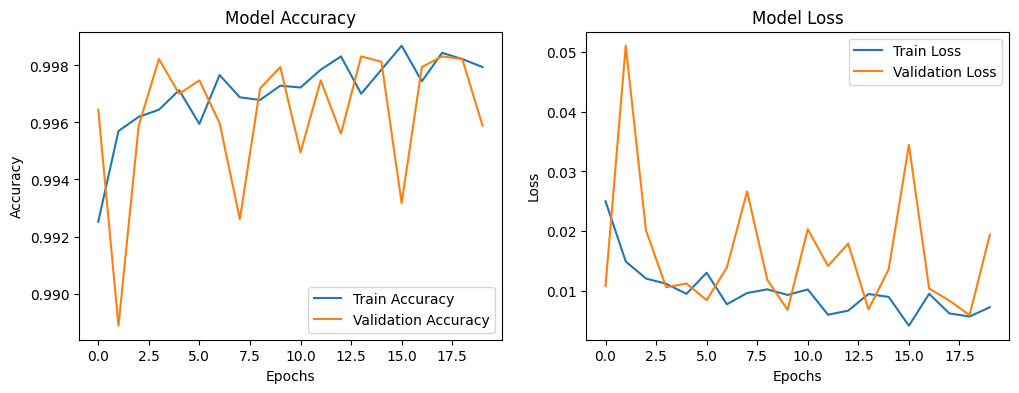

In [11]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [12]:
# Predict class probabilities for the entire dataset
y_pred = model.predict(X_patches)
y_pred_classes = np.argmax(y_pred, axis=1) + 1  # Convert one-hot back to class index

# Initialize an empty label map
label_map = np.zeros((610, 340), dtype=int)

# Assign predictions back to original positions
indices = np.where(labels > 0)  # Get non-zero label positions
for i, (row, col) in enumerate(zip(indices[0], indices[1])):
    label_map[row, col] = y_pred_classes[i]

print(f"Predicted Label Map Shape: {label_map.shape}")  # (145, 145)


1337/1337 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Predicted Label Map Shape: (610, 340)


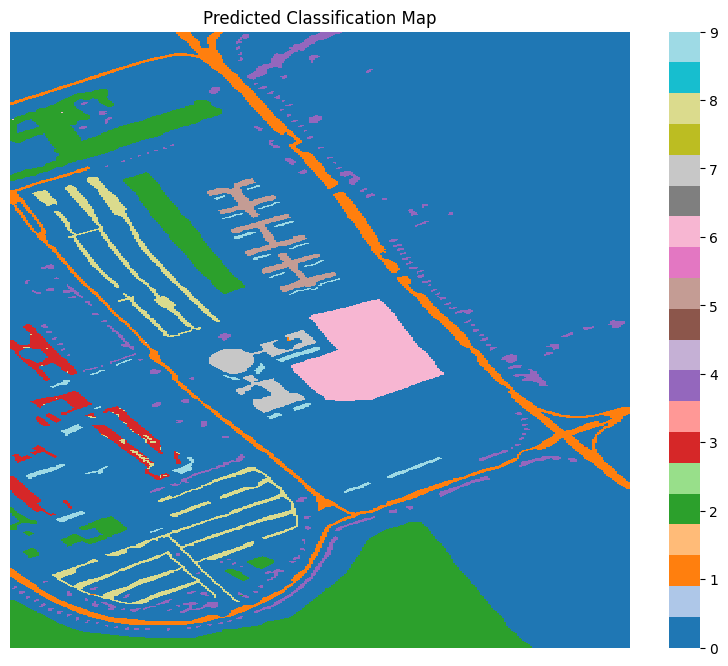

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(label_map, cmap='tab20', xticklabels=False, yticklabels=False)
plt.title("Predicted Classification Map")
plt.show()


In [14]:
from sklearn.metrics import classification_report

# Extract true labels from one-hot encoding
y_true = np.argmax(y_test, axis=1) + 1  # Convert one-hot back to class index

# Compute and display precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Classification Report:


ValueError: Found input variables with inconsistent numbers of samples: [10694, 42776]